In [ ]:
# default_exp vision

In [ ]:
#export
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.distributed import *
from torchvision.models import *
from fastai.vision.models.xresnet import *
from fastai.callback.mixup import *
import fastprogress

# Image Benchmarks

> An XResnet50

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

In [ ]:
#export
def get_dls(size, woof, bs, sh=0., workers=None):
    if size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else        : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    batch_tfms = [Normalize.from_stats(*imagenet_stats)]
    if sh: batch_tfms.append(RandomErasing(p=0.3, max_count=3, sh=sh))
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label,
                       item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)],
                       batch_tfms=batch_tfms)
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)


In [ ]:
dls = get_dls(128, 0, bs=64)

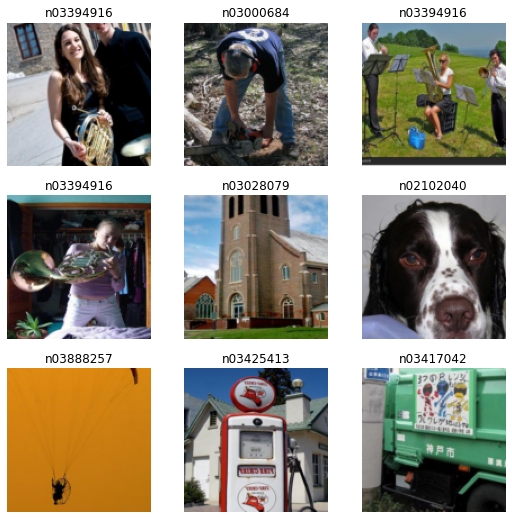

In [ ]:
dls.show_batch()

In [ ]:
#export
def train(
    gpu=None,
    woof=0,
    lr=1e-2,
    size=128,
    sqrmom=0.99,
    mom=0.9,
    eps=1e-6,
    epochs=5,
    bs=64,
    mixup=0.,
    opt='ranger',
    arch='xresnet50',
    sh=0.,
    sa=0,
    sym=0,
    beta=0.,
    act_fn='Mish',
    fp16=0,
    pool='AvgPool',
    dump=0,
    runs=1,
    meta=''
):
    "Training of Imagenette."
    print(f' {arch=}; {opt=}; {epochs=}; {bs=}; {fp16=}; {runs=}')
    # gpu = setup_distrib(gpu)
    if gpu is not None: torch.cuda.set_device(gpu)
    if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
    elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=sqrmom)
    elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
    elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

    dls = get_dls(size, woof, bs, sh=sh)
    m,act_fn,pool = [globals()[o] for o in (arch,act_fn,pool)]

    for run in range(runs):
        print(f' Run: {run}')
        learn = Learner(dls, m(n_out=10, act_cls=act_fn, sa=sa, sym=sym, pool=pool, pretrained=False), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
        if dump: print(learn.model); exit()
        if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []

        n_gpu = torch.cuda.device_count()

        # The old way to use DataParallel, or DistributedDataParallel training:
        # if gpu is None and n_gpu: learn.to_parallel()
        # if num_distrib()>1: learn.to_distributed(gpu) # Requires `-m fastai.launch`

        # the context manager way of dp/ddp, both can handle single GPU base case.
        ctx = learn.parallel_ctx if gpu is None and n_gpu else learn.distrib_ctx

        with partial(ctx, gpu)(): # distributed traing requires "-m fastai.launch"
            learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

In [ ]:
#export
def train_imagenette(gpu=None, bs=64, fp16=0, epochs=5, runs=1):
    train(gpu=gpu, bs=bs, fp16=fp16, act_fn='Mish', opt='ranger', epochs=epochs, runs=runs)

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()